In [19]:
import yaml

import numpy as np
import matplotlib.pyplot as plt

import soepy
from notebooks.estimagic.auxiliary import prepare_estimation
from notebooks.estimagic.auxiliary import get_moments
from notebooks.estimagic.SimulationBasedEstimation import SimulationBasedEstimationCls

In [11]:
lower = np.tile(
    (
        1.000,
        1.000,
        1.000,
        0.050,
        0.050,
        0.050,
        0.005,
        0.005,
        0.005,
        0.001,
        0.001,
        0.001,
        1.00,
        1.00,
        -0.400,
        -0.800,
        -0.400,
        -0.800,
        0.001,
        0.001,
        0.001,
        0.001,
        0.001,
    ),
    1,
)

upper = np.tile(
    (
        3.000,
        3.000,
        3.000,
        0.400,
        0.400,
        0.400,
        0.600,
        0.600,
        0.600,
        0.150,
        0.150,
        0.150,
        4.00,
        4.00,
        -0.050,
        -0.150,
        -0.050,
        -0.150,
        0.999,
        0.999,
        0.800,
        0.800,
        0.800,
    ),
    1,
)

model_params_init_file_name = "init_files/toy_model_init_file_03_3types.pkl"
model_spec_init_file_name = "init_files/model_spec_init_delta_test.yml"
data_file_name = "init_files/data_obs_3types_9000.pkl"
log_file_name_extension = "change_delta"


moments_obs, weighting_matrix, model_params_df = prepare_estimation(
    model_params_init_file_name, model_spec_init_file_name, data_file_name, lower, upper
)

max_evals = 10

delta_container = [0.98, 0.95, 0.90, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, 0.98]

fval = np.full(len(delta_container), np.nan)

i = 0

for delta in delta_container:

    with open("init_files/model_spec_init_delta_test.yml") as f:
         model_spec_init = yaml.load(f, Loader=yaml.FullLoader)

    model_spec_init["CONSTANTS"]["delta"] = delta
    print(delta)

    with open("init_files/model_spec_init_delta_test.yml", "w") as f:
        yaml.dump(model_spec_init, f)

    adapter_smm = SimulationBasedEstimationCls(
        params=model_params_df,
        model_spec_init_file_name=model_spec_init_file_name,
        moments_obs=moments_obs,
        weighting_matrix=weighting_matrix,
        get_moments=get_moments,
        log_file_name_extension=log_file_name_extension,
        max_evals=max_evals,
    )

    fval[i] = SimulationBasedEstimationCls.get_objective(adapter_smm, model_params_df)
    i += 1

0.98
0.43486846705627996
0.95
0.924594362700641
0.9
3.1125659222425472
0.85
6.621430976903864
0.8
10.75091149829092
0.7
19.697829850289217
0.6
30.00487784745781
0.5
40.14548259571073
0.4
50.13985298777073
0.3
58.99918659115072
0.2
68.33487836882185
0.1
77.09183191844271
0.0
85.433094313673
0.98
0.43486846705627996


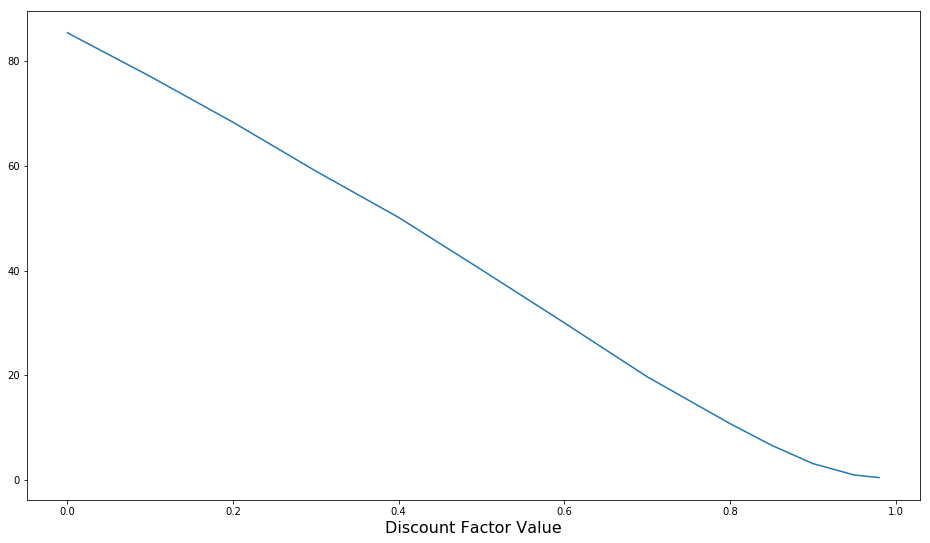

In [17]:
# Start plot
ax = plt.figure(figsize=[16,9]).add_subplot(111)
ax.set_xlabel("Discount Factor Value", fontsize=16)

plt.plot(delta_container[:-1], fval[:-1])

In [20]:
data_sim_delta0 = soepy.simulate("init_files/toy_model_init_file_03_3types.pkl", "init_files/model_spec_init_test_delta0_30000.yml")

In [21]:
data_sim_delta098 = soepy.simulate("init_files/toy_model_init_file_03_3types.pkl", "init_files/model_spec_init.yml")

In [22]:
def get_moments(data):
    # Pre_process data frame

    # Determine the education level given years of experience
    data["Educ_Level"] = 0
    data.loc[data["Years_of_Education"] == 11, "Educ_Level"] = 1
    data.loc[data["Years_of_Education"] == 12, "Educ_Level"] = 2

    # Determine the observed wage given period choice
    data["Wage_Observed"] = 0
    data.loc[data["Choice"] == 0, "Wage_Observed"] = data.loc[
        data["Choice"] == 0, "Period_Wage_N"
    ]
    data.loc[data["Choice"] == 1, "Wage_Observed"] = data.loc[
        data["Choice"] == 1, "Period_Wage_P"
    ]
    data.loc[data["Choice"] == 2, "Wage_Observed"] = data.loc[
        data["Choice"] == 2, "Period_Wage_F"
    ]

    # Calculate moments

    # Initialize moments dictionary
    moments = dict()

    # Store moments in groups as nested dictionary
    for group in ["Wage_Distribution", "Choice_Probability"]:
        moments[group] = dict()

    # Compute unconditional moments of the wage distribution
    info = data.groupby(["Period"])["Wage_Observed"].describe().to_dict()

    # Save mean and standard deviation of wages for each period
    # to Wage Distribution section of the moments dictionary
    for period in range(30):  ## TO DO: Remove hard coded number
        moments["Wage_Distribution"][period] = []
        try:
            for label in ["mean", "std"]:
                moments["Wage_Distribution"][period].append(info[label][period])
        except KeyError:
            for i in range(2):
                moments["Wage_Distribution"][period].append(0.0)

    # Compute unconditional moments of the choice probabilities
    info = data.groupby(["Period"])["Choice"].value_counts(normalize=True).to_dict()

    for period in range(30):  ## TO DO: Remove hard coded number
        moments["Choice_Probability"][period] = []
        for choice in range(3):
            try:
                stat = info[(period, choice)]
            except KeyError:
                stat = 0.00
            moments["Choice_Probability"][period].append(stat)

    return moments

In [23]:
delta0_sim_moments = get_moments(data_sim_delta0)
delta098_sim_moments = get_moments(data_sim_delta098)

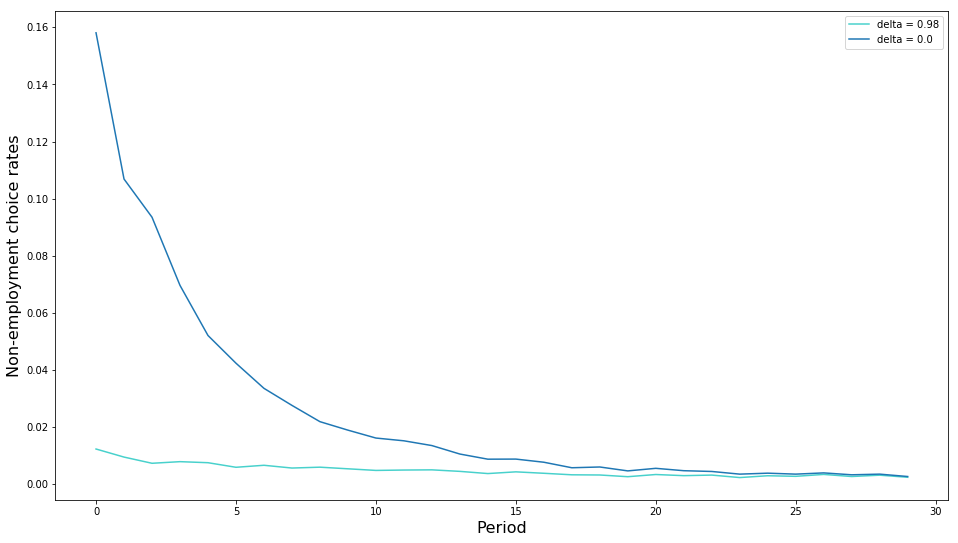

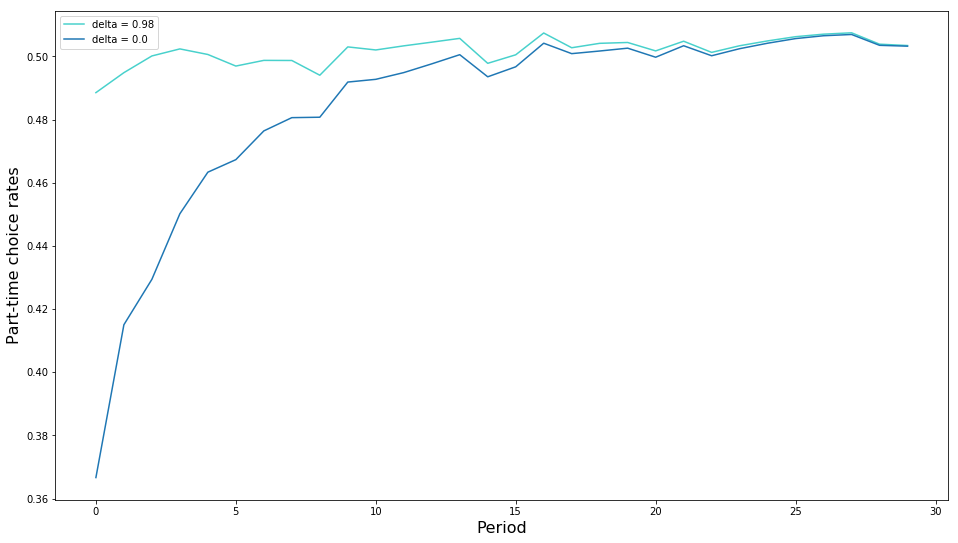

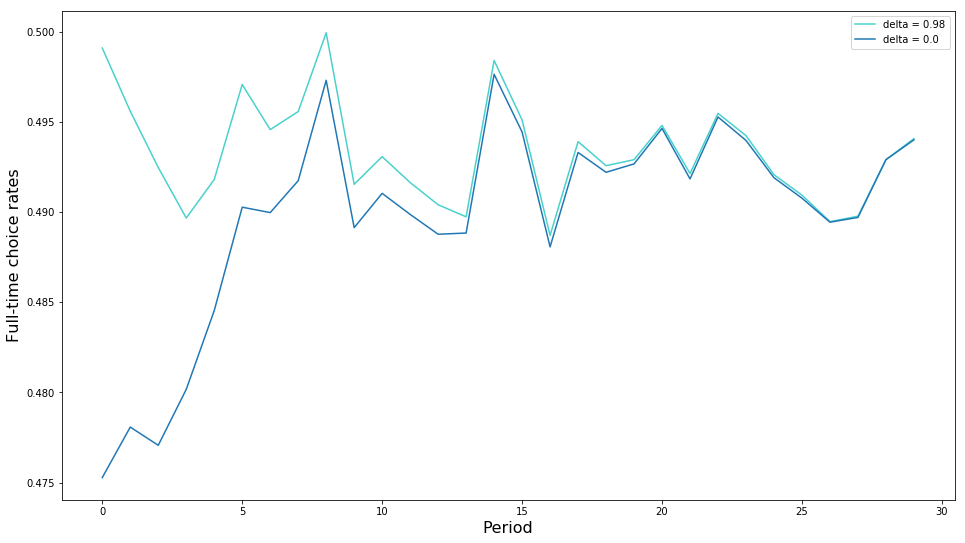

In [26]:
lables = ["Non-employment choice rates", "Part-time choice rates", "Full-time choice rates"]
for choice in range(3):

    delta098_choice_prob = []
    for _, value in delta098_sim_moments["Choice_Probability"].items():
        temp = [_, value]
        delta098_choice_prob.append(temp[1][choice])

    delta0_choice_prob = []
    for _, value in delta0_sim_moments["Choice_Probability"].items():
        temp = [_, value]
        delta0_choice_prob.append(temp[1][choice])
        
    x = np.arange(30)

    # Start plot
    ax = plt.figure(figsize=[16,9]).add_subplot(111)
    ax.set_ylabel(lables[choice], fontsize=16)
    ax.set_xlabel("Period", fontsize=16)

    plt.plot(x, delta098_choice_prob, color = 'mediumturquoise')
    plt.plot(x, delta0_choice_prob)

    ax.legend(["delta = 0.98", "delta = 0.0"])

    #plt.savefig('choice_prob_cf.png', bbox_inches='tight')